In [271]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [294]:
import math
import random
from PIL import Image as image
from collections import defaultdict
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
%matplotlib inline

ops = {'go': 0, 'turn_left': 1, 'turn_right': 2}
cells = {'empty': 0, 'visited': 1}

def visited_surrounding(bitmap, x, y):
    num_visited = 0
    for delx in [-1, 0, 1]:
        for dely in [-1, 0, 1]:
            if bitmap[-(y+dely)][x+delx] == cells['visited']:
                num_visited += 1
    return num_visited

def try_generate_program(program_length, p_turn):
    bitmap = defaultdict(lambda: defaultdict(lambda: cells['empty']))
    program = []
    x = y = phi = 0
    bitmap[-y][x] = cells['visited']
    for i in xrange(program_length):
        if random.random() >= p_turn:
            op = ops['go']
            x += round(math.cos(phi))
            y += round(math.sin(phi))
            if bitmap[-y][x] != cells['empty']:
                return None
            else:
                bitmap[-y][x] = cells['visited']
            if visited_surrounding(bitmap, x, y) > 3:
                return None
        else:
            if random.random() < 0.5:
                op = ops['turn_left']
                phi += math.pi/2
                if len(program) > 0 and program[-1] == ops['turn_right']:
                    return None
            else:
                op = ops['turn_right']
                phi -= math.pi/2
                if len(program) > 0 and program[-1] == ops['turn_left']:
                    return None
        program.append(op)
    return program, bitmap

def generate_program(program_length, p_turn):
    for _ in xrange(1000):
        r = try_generate_program(program_length, p_turn)
        if r is not None:
            return r

def generate_programs(num_programs=1000, program_length=24, p_turn=0.3):
    lookup = set()
    width = height = program_length*2+1
    programs = np.zeros((num_programs, program_length, 3))
    bitmaps = np.zeros((num_programs, width * height))
    i = 0
    while i < num_programs:
        program, bitmap = generate_program(program_length, p_turn)
        program = tuple(program)
        if tuple(program) not in lookup:
            lookup.add(tuple(program))
            for k in xrange(program_length):
                programs[i, k, program[k]] = 1 # one-hot
            ai = 0
            for w in xrange(-program_length, program_length):
                for h in xrange(-program_length, program_length):
                    bitmaps[i, ai] = bitmap[w][h]
                    ai += 1    
            i += 1
            print(i, end='   \r')
    return programs, bitmaps

def to_program(program):
    inv_ops = {v: k for k, v in ops.iteritems()}
    rp = []
    for i in xrange(len(program)):
        for k in xrange(len(program[i])):
            if program[i][k] == 1:
                rp.append(inv_ops[k])
    return rp

def show_bitmap(bitmap, program_length):
    width = height = program_length*2+1
    data = np.zeros((width, height))
    ia = 0
    for w in xrange(-program_length, program_length):
        for h in xrange(-program_length, program_length):
            data[w+program_length, h+program_length] = bitmap[ia]
            ia += 1
    plt.axis('off')
    plt.imshow(data, cmap=plt.cm.gray, aspect='equal')
    
def get_training_batch(programs, bitmaps, batch_programs, batch_bitmaps, batch_size, p_training):
    batch_programs.fill(0)
    batch_bitmaps.fill(0)
    for i in xrange(batch_size):
        r = int(random.random() * len(programs) * p_training)
        batch_programs[i] = programs[r]
        batch_bitmaps[i] = bitmaps[r]

def get_test_batch(programs, bitmaps, test_programs, test_bitmaps, test_size, p_training):
    test_programs.fill(0)
    test_bitmaps.fill(0)
    offset = int(p_training * len(programs))
    for i in xrange(test_size):
        test_programs[i] = programs[offset+i]
        test_bitmaps[i] = bitmaps[offset+i]

['go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']


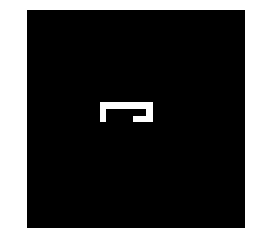

In [295]:
program_length=16
num_programs=1*1000
programs, bitmaps = generate_programs(num_programs, program_length, p_turn=0.3)
print(to_program(programs[0]))
show_bitmap(bitmaps[0], program_length)

In [225]:
width = height = program_length*2+1
x = tf.placeholder(tf.float32, [None, width*height])
# x is the input image as a long row vector
W = tf.Variable(tf.zeros([width*height, program_length * len(ops.keys())]))
# W are the weights, going from each input to output, where each output op is one-hot encoded
b = tf.Variable(tf.zeros([program_length * len(ops.keys())]))
# b are the biases for each output
#y = tf.nn.softmax(tf.reshape(tf.matmul(x, W) + b, [-1, program_length, len(ops.keys())]), dim=2)
y = tf.reshape(tf.matmul(x, W) + b, [-1, program_length, len(ops.keys())])
# y are the predicted program for each x, one-hot encoded, so it's shape is num_programs x program_length x num_ops
y_ = tf.placeholder(tf.float32, [None, program_length, len(ops.keys())])
# y_ is the correct one-hot encoded program, for computing cross-entropy
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])) # loss function is cross_entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
num_training_runs = 10*1000
batch_size = 100
p_training = 0.9
width = height = program_length*2+1
batch_programs = np.zeros((batch_size, program_length, 3))
batch_bitmaps = np.zeros((batch_size, width * height))
for i in range(num_training_runs):
    get_training_batch(programs, bitmaps, batch_programs, batch_bitmaps, batch_size, p_training)
    _, train_error, weights, bias = sess.run([train_step, cross_entropy, W, b], feed_dict={x: batch_bitmaps, y_: batch_programs})
    print((i, train_error), end='   \r')

np.set_printoptions(threshold=np.nan)
#print(weights)
print(bias)

#correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

test_size = int(len(programs) * (1.0 - p_training))
test_programs = np.zeros((test_size, program_length, 3))
test_bitmaps = np.zeros((test_size, width * height))
get_test_batch(programs, bitmaps, test_programs, test_bitmaps, test_size, p_training)

#print(sess.run(accuracy, feed_dict={x: test_bitmaps, y_: test_programs}))

actuals = sess.run(y_, feed_dict={x: test_bitmaps, y_: test_programs})
prediction_probas = sess.run(y, feed_dict={x: test_bitmaps, y_: test_programs})

predictions = np.zeros((len(prediction_probas), program_length, 3))
for i in xrange(len(prediction_probas)):
    for j in xrange(program_length):
        max_proba = 0
        which = 0
        for k in xrange(len(ops.keys())):
            if prediction_probas[i][j][k] > max_proba:
                which = k
                max_proba = prediction_probas[i][j][k]
        predictions[i][j][which] = 1

[-0.09241431  0.04535684  0.0470571   0.24307013 -0.12756351 -0.11550715
  0.28640246 -0.15375225 -0.13265088  0.38347337 -0.19360229 -0.18987121
  0.38519049 -0.19266117 -0.19253001  0.42073902 -0.23272651 -0.18801153
  0.42285046 -0.21470191 -0.20814875  0.40835086 -0.2152489  -0.19310181
  0.43474439 -0.21465695 -0.22008687  0.4161123  -0.19352558 -0.22258602
  0.4388842  -0.21811834 -0.22076477  0.39456907 -0.19517522 -0.19939367
  0.39978239 -0.21552373 -0.18425848  0.39627376 -0.19740278 -0.19887199
  0.38278812 -0.19669154 -0.18609641  0.35725912 -0.17978504 -0.17747438
  0.40071449 -0.18656458 -0.21415013  0.36325878 -0.18129012 -0.18196882
  0.34057429 -0.17317824 -0.16739714  0.33806407 -0.15571056 -0.18235296
  0.35332581 -0.21370396 -0.13962251  0.3322247  -0.1562347  -0.17598909
  0.31816316 -0.15749218 -0.16067149  0.2805447  -0.11835641 -0.16218784]


In [227]:
index = 568
print(to_program(actuals[index]))
print(to_program(predictions[index]))
print(actuals[index])
print(predictions[index])

['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_right', 'turn_right', 'turn_left', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]]
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0

In [228]:
def num_go(li, program_length):
    num_go = 0
    for i in xrange(len(li)):
        for j in xrange(program_length):
            if li[i][j][0] == 1: num_go += 1
    return num_go
num_predictions_go = num_go(predictions, program_length)
num_actuals_go = num_go(actuals, program_length)
print(float(num_predictions_go) / (len(predictions) * program_length))
print(float(num_actuals_go) / (len(actuals) * program_length))

0.965382048715
0.725392058725


In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W_conv = weight_variable([3, 3, 1, program_length * len(ops.keys())])
x_image = tf.reshape(x, [-1, width, height, 1])
h_conv = tf.nn.relu(conv2d(x_image, W_conv))
h_pool = max_pool_2x2(h_conv)
reduced_width = int(math.ceil(float(width)/2))
reduced_height = int(math.ceil(float(height)/2))
h_pool_reshaped = tf.reshape(h_pool, [-1, reduced_width * reduced_height * program_length * len(ops.keys())])
W = weight_variable([reduced_width * reduced_height * program_length * len(ops.keys()), program_length * len(ops.keys())])
b = bias_variable([program_length * len(ops.keys())])
h = tf.nn.relu(tf.matmul(h_pool_reshaped, W) + b)
y = tf.reshape(h, [-1, program_length, len(ops.keys())])
y_ = tf.placeholder(tf.float32, [None, program_length, len(ops.keys())])
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
num_training_runs = 10*1000
batch_size = 100
p_training = 0.9
width = height = program_length*2+1
batch_programs = np.zeros((batch_size, program_length, 3))
batch_bitmaps = np.zeros((batch_size, width * height))
for i in range(num_training_runs):
    get_training_batch(programs, bitmaps, batch_programs, batch_bitmaps, batch_size, p_training)
    _, train_error = sess.run([train_step, cross_entropy], feed_dict={x: batch_bitmaps, y_: batch_programs})
    print((i, train_error), end='   \r')

In [207]:
actuals = sess.run(y_, feed_dict={x: test_bitmaps, y_: test_programs})
prediction_probas = sess.run(y, feed_dict={x: test_bitmaps, y_: test_programs})

predictions = np.zeros((len(prediction_probas), program_length, 3))
for i in xrange(len(prediction_probas)):
    for j in xrange(program_length):
        max_proba = 0
        which = 0
        for k in xrange(len(ops.keys())):
            if prediction_probas[i][j][k] > max_proba:
                which = k
                max_proba = prediction_probas[i][j][k]
        predictions[i][j][which] = 1

In [223]:
index = 49
print(to_program(actuals[index]))
print(to_program(predictions[index]))
print(actuals[index])
print(predictions[index])

['go', 'go', 'turn_right', 'turn_right', 'turn_left', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]


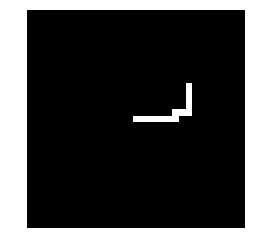

In [270]:
show_bitmap(bitmaps[6], program_length)

In [ ]:
state_size = width * height * 2
width = height = program_length*2+1
batch_programs = np.zeros((batch_size, program_length, 3))
batch_bitmaps = np.zeros((batch_size, width * height))

tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, width * height * program_length])
y_ = tf.placeholder(tf.int32, [None, program_length, len(ops.keys())])
init_state = tf.placeholder(tf.float32, [batch_size, state_size])
labels_series = tf.unstack(y_, axis=1)
inputs_series = tf.split(x, program_length, 1)
cell = tf.contrib.rnn.BasicRNNCell(state_size)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

W = tf.Variable(np.random.rand(state_size, len(ops.keys())), dtype=tf.float32)
b = tf.Variable(np.zeros((1, len(ops.keys()))), dtype=tf.float32)
logits_series = [tf.matmul(state, W) + b for state in states_series]
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]
losses = [tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series, labels_series)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(0.1).minimize(total_loss)

test_size = int(len(programs) * (1.0 - p_training))
test_programs = np.zeros((test_size, program_length, 3))
test_bitmaps = np.zeros((test_size, width * height))
get_test_batch(programs, bitmaps, test_programs, test_bitmaps, test_size, p_training)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch_idx in range(100):
        _current_state = np.zeros((batch_size, state_size))
        print("New data, epoch", epoch_idx)
        for batch_idx in range(100):
            get_training_batch(programs, bitmaps, batch_programs, batch_bitmaps, batch_size, p_training)
            repeated_batch_bitmaps = np.tile(batch_bitmaps, [1, program_length])
            _total_loss, _train_step, _current_state, _predictions_series = sess.run([total_loss, train_step, current_state, predictions_series], feed_dict={x: repeated_batch_bitmaps, y_: batch_programs, init_state:_current_state})
            print("Step", batch_idx, "Loss", _total_loss)
            if _total_loss < 1.0:
                get_training_batch(test_programs, test_bitmaps, batch_programs, batch_bitmaps, batch_size, p_training=1.0)
                repeated_batch_bitmaps = np.tile(batch_bitmaps, [1, program_length])
                actuals, prediction_probas = sess.run([y_, predictions_series], feed_dict={x: repeated_batch_bitmaps, y_: batch_programs, init_state: _current_state})
                predictions = np.zeros((len(prediction_probas), program_length, 3))
                for i in xrange(len(prediction_probas)):
                    for j in xrange(program_length):
                        max_proba = 0
                        which = 0
                        for k in xrange(len(ops.keys())):
                            if prediction_probas[i][j][k] > max_proba:
                                which = k
                                max_proba = prediction_probas[i][j][k]
                        predictions[i][j][which] = 1
                for index in xrange(10):
                    print(to_program(actuals[index]))
                    print(to_program(predictions[index]))

New data, epoch 0
Step 0 Loss 1.0416
Step 1 Loss 38.0742
Step 2 Loss 71.1151
Step 3 Loss 121.426
Step 4 Loss 59.5104
Step 5 Loss 109.744
Step 6 Loss 19.7985
Step 7 Loss 93.5513
Step 8 Loss 10.1652
Step 9 Loss 109.287
Step 10 Loss 9.28833
Step 11 Loss 88.6916
Step 12 Loss 4.09379
Step 13 Loss 63.1706
Step 14 Loss 17.624
Step 15 Loss 60.2691
Step 16 Loss 13.8937
Step 17 Loss 56.1643
Step 18 Loss 12.0547
Step 19 Loss 49.0489
Step 20 Loss 10.4395
Step 21 Loss 46.668
Step 22 Loss 8.6414
Step 23 Loss 44.1059
Step 24 Loss 7.42466
Step 25 Loss 31.9624
Step 26 Loss 31.9733
Step 27 Loss 27.8421
Step 28 Loss 31.601
Step 29 Loss 20.8232
Step 30 Loss 32.2736
Step 31 Loss 18.5623
Step 32 Loss 31.183
Step 33 Loss 16.8578
Step 34 Loss 29.2059
Step 35 Loss 17.4256
Step 36 Loss 27.2406
Step 37 Loss 16.7782
Step 38 Loss 26.1919
Step 39 Loss 14.3421
Step 40 Loss 25.6135
Step 41 Loss 14.0941
Step 42 Loss 25.9632
Step 43 Loss 12.8438
Step 44 Loss 26.1792
Step 45 Loss 10.8432
Step 46 Loss 24.4085
Step 47 Los

Step 91 Loss 4.92885
Step 92 Loss 3.0046
Step 93 Loss 4.96876
Step 94 Loss 2.77286
Step 95 Loss 4.49858
Step 96 Loss 2.61637
Step 97 Loss 4.65056
Step 98 Loss 2.69214
Step 99 Loss 4.70122
New data, epoch 4
Step 0 Loss 4.64985
Step 1 Loss 2.02019
Step 2 Loss 4.89115
Step 3 Loss 10.4929
Step 4 Loss 4.24907
Step 5 Loss 9.66847
Step 6 Loss 4.61805
Step 7 Loss 9.93741
Step 8 Loss 4.7797
Step 9 Loss 9.60593
Step 10 Loss 5.0215
Step 11 Loss 10.3319
Step 12 Loss 3.48307
Step 13 Loss 10.0518
Step 14 Loss 4.34136
Step 15 Loss 10.7463
Step 16 Loss 3.50723
Step 17 Loss 10.3601
Step 18 Loss 3.66676
Step 19 Loss 10.6218
Step 20 Loss 3.99797
Step 21 Loss 9.84205
Step 22 Loss 3.51084
Step 23 Loss 10.4204
Step 24 Loss 3.39845
Step 25 Loss 9.46374
Step 26 Loss 3.85191
Step 27 Loss 9.79654
Step 28 Loss 3.70861
Step 29 Loss 9.80085
Step 30 Loss 3.58288
Step 31 Loss 9.63261
Step 32 Loss 3.82335
Step 33 Loss 9.22243
Step 34 Loss 3.84664
Step 35 Loss 9.1545
Step 36 Loss 3.46624
Step 37 Loss 9.54897
Step 38 L

Step 83 Loss 1.3139
Step 84 Loss 1.33664
Step 85 Loss 1.31207
Step 86 Loss 1.37375
Step 87 Loss 1.40945
Step 88 Loss 1.41915
Step 89 Loss 1.34021
Step 90 Loss 1.463
Step 91 Loss 1.40957
Step 92 Loss 1.43443
Step 93 Loss 1.34912
Step 94 Loss 1.2935
Step 95 Loss 1.37428
Step 96 Loss 1.30154
Step 97 Loss 1.42536
Step 98 Loss 1.33675
Step 99 Loss 1.36235
New data, epoch 8
Step 0 Loss 4.66107
Step 1 Loss 1.28073
Step 2 Loss 1.35232
Step 3 Loss 1.32027
Step 4 Loss 1.39314
Step 5 Loss 1.19947
Step 6 Loss 1.39839
Step 7 Loss 1.42539
Step 8 Loss 1.31334
Step 9 Loss 1.41892
Step 10 Loss 1.29877
Step 11 Loss 1.36671
Step 12 Loss 1.4154
Step 13 Loss 1.32669
Step 14 Loss 1.37006
Step 15 Loss 1.33578
Step 16 Loss 1.34316
Step 17 Loss 1.24754
Step 18 Loss 1.28038
Step 19 Loss 1.31631
Step 20 Loss 1.4411
Step 21 Loss 1.36006
Step 22 Loss 1.37491
Step 23 Loss 1.33745
Step 24 Loss 1.42982
Step 25 Loss 1.31667
Step 26 Loss 1.29324
Step 27 Loss 1.39824
Step 28 Loss 1.35424
Step 29 Loss 1.30542
Step 30 Los

Step 74 Loss 1.06079
Step 75 Loss 1.06947
Step 76 Loss 1.10964
Step 77 Loss 1.12798
Step 78 Loss 1.18119
Step 79 Loss 1.04921
Step 80 Loss 1.13711
Step 81 Loss 1.06898
Step 82 Loss 1.11288
Step 83 Loss 1.04298
Step 84 Loss 1.02276
Step 85 Loss 1.06025
Step 86 Loss 0.977149
['turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go'

Step 6 Loss 0.998065
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go',

Step 15 Loss 1.12765
Step 16 Loss 1.01532
Step 17 Loss 1.03247
Step 18 Loss 0.994619
['turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go',

Step 51 Loss 1.00456
Step 52 Loss 0.997919
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go',

Step 62 Loss 0.932201
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_lef

Step 66 Loss 0.955899
['go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go'

Step 76 Loss 0.983784
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 

Step 84 Loss 1.00383
Step 85 Loss 1.02831
Step 86 Loss 1.01745
Step 87 Loss 1.00728
Step 88 Loss 0.969265
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'tu

Step 96 Loss 1.05859
Step 97 Loss 1.04882
Step 98 Loss 0.974666
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 't

Step 7 Loss 0.993939
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go

Step 11 Loss 0.940454
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 't

Step 16 Loss 0.92661
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'g

Step 21 Loss 0.995694
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', '

Step 25 Loss 1.00087
Step 26 Loss 0.969594
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right

Step 34 Loss 0.971066
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go

Step 39 Loss 0.956966
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go

Step 43 Loss 0.917895
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn

Step 47 Loss 0.987307
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn

Step 52 Loss 0.867567
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go',

Step 56 Loss 0.934761
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'g

Step 60 Loss 0.948257
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go',

Step 64 Loss 0.911812
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'tu

Step 68 Loss 0.932121
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left',

Step 72 Loss 0.983607
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go'

Step 76 Loss 0.900063
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', '

Step 80 Loss 0.956821
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 

Step 84 Loss 0.96935
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go

Step 89 Loss 0.926193
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'g

Step 93 Loss 0.927278
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'g

Step 98 Loss 0.928448
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_ri

Step 3 Loss 0.930528
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'tu

Step 7 Loss 0.875259
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_r

Step 12 Loss 0.865237
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', '

Step 16 Loss 0.904034
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go

Step 20 Loss 0.89008
['turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 

Step 24 Loss 0.901431
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_

Step 28 Loss 0.897484
['turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_

Step 32 Loss 0.906524
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right

Step 36 Loss 0.934877
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right',

Step 40 Loss 0.900617
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go

Step 44 Loss 0.922868
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go

Step 48 Loss 0.917524
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go',

Step 52 Loss 0.89119
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_

Step 56 Loss 0.906375
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 

Step 60 Loss 0.907628
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go'

Step 64 Loss 0.911633
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 

Step 68 Loss 0.864535
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn

Step 72 Loss 0.874176
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go',

Step 76 Loss 0.864761
['go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go',

Step 80 Loss 0.884517
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go'

Step 84 Loss 0.884774
['turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn

Step 88 Loss 0.887177
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left'

Step 92 Loss 0.878239
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'g

Step 96 Loss 0.910339
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 

Step 0 Loss 1.86899
Step 1 Loss 0.911476
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go'

Step 5 Loss 0.855525
['turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_rig

Step 9 Loss 0.900063
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go']


Step 13 Loss 0.860234
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go'

Step 17 Loss 0.80936
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 't

Step 21 Loss 0.855853
['turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go',

Step 25 Loss 0.867503
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left

Step 29 Loss 0.828416
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', '

Step 33 Loss 0.826986
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'g

Step 37 Loss 0.812652
['go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go'

Step 41 Loss 0.833892
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go',

Step 45 Loss 0.902274
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go

Step 49 Loss 0.9224
['turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'g

Step 53 Loss 0.829884
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'go', 'g

Step 57 Loss 0.842295
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go'

Step 61 Loss 0.870326
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go'

Step 65 Loss 0.858813
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['

Step 69 Loss 0.827135
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', '

Step 73 Loss 0.81565
['turn_right', 'turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn

Step 77 Loss 0.780238
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', '

Step 81 Loss 0.852482
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_

Step 85 Loss 0.844637
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go

Step 89 Loss 0.868185
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go'

Step 93 Loss 0.879804
['turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 't

Step 97 Loss 0.861388
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go'

Step 2 Loss 1.02231
Step 3 Loss 1.54631
Step 4 Loss 4.53121
Step 5 Loss 3.77481
Step 6 Loss 4.72528
Step 7 Loss 3.33028
Step 8 Loss 4.8794
Step 9 Loss 3.11492
Step 10 Loss 5.41852
Step 11 Loss 3.08916
Step 12 Loss 5.48115
Step 13 Loss 3.05711
Step 14 Loss 5.42755
Step 15 Loss 3.04536
Step 16 Loss 5.385
Step 17 Loss 2.78025
Step 18 Loss 5.06252
Step 19 Loss 2.74672
Step 20 Loss 5.02189
Step 21 Loss 3.21058
Step 22 Loss 5.04771
Step 23 Loss 3.1236
Step 24 Loss 4.46568
Step 25 Loss 3.38199
Step 26 Loss 4.52323
Step 27 Loss 3.43585
Step 28 Loss 4.92883
Step 29 Loss 3.19739
Step 30 Loss 4.81456
Step 31 Loss 3.63478
Step 32 Loss 4.5305
Step 33 Loss 3.70966
Step 34 Loss 4.32599
Step 35 Loss 3.58371
Step 36 Loss 3.86481
Step 37 Loss 3.3638
Step 38 Loss 4.02864
Step 39 Loss 3.78347
Step 40 Loss 4.25109
Step 41 Loss 3.30748
Step 42 Loss 4.12544
Step 43 Loss 3.65259
Step 44 Loss 4.63984
Step 45 Loss 3.05581
Step 46 Loss 4.91496
Step 47 Loss 2.96199
Step 48 Loss 4.51934
Step 49 Loss 2.99981
Step 5

Step 4 Loss 0.980401
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_

Step 8 Loss 0.989211
['go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 

Step 12 Loss 1.01184
Step 13 Loss 0.885004
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go

Step 18 Loss 0.958514
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_righ

Step 22 Loss 1.03237
Step 23 Loss 0.975088
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go'

Step 27 Loss 0.978677
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go'

Step 31 Loss 0.985341
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go

Step 35 Loss 0.952635
['turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go'

Step 39 Loss 0.943912
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_

Step 44 Loss 0.943133
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'tu

Step 48 Loss 0.919871
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 't

Step 53 Loss 0.91389
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 

Step 57 Loss 1.02197
Step 58 Loss 0.969255
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', '

Step 62 Loss 1.01949
Step 63 Loss 0.945614
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'tu

Step 67 Loss 0.928253
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_l

Step 71 Loss 0.944725
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right

Step 75 Loss 0.865247
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go

Step 79 Loss 0.946364
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go',

Step 84 Loss 0.932729
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go

Step 88 Loss 0.860442
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go',

Step 92 Loss 0.983254
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'g

Step 96 Loss 0.971329
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_rig

Step 0 Loss 2.50229
Step 1 Loss 0.924241
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right'

Step 5 Loss 0.941148
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', '

Step 9 Loss 1.00918
Step 10 Loss 0.897547
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 

Step 14 Loss 0.934036
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'tu

Step 18 Loss 0.927583
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn

Step 22 Loss 0.900338
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go'

Step 26 Loss 0.962948
['turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go'

Step 30 Loss 0.931815
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', '

Step 34 Loss 0.923401
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left'

Step 38 Loss 0.85166
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'g

Step 42 Loss 0.887001
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'tu

Step 46 Loss 0.876591
['turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go

Step 50 Loss 0.923248
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'tur

Step 54 Loss 0.916471
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go',

Step 58 Loss 0.938458
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_righ

Step 62 Loss 0.854639
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go

Step 66 Loss 0.905542
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right

Step 70 Loss 0.850415
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 

Step 74 Loss 0.905326
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go']
['

Step 78 Loss 0.906645
['turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go'

Step 82 Loss 0.895539
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go',

Step 86 Loss 0.879676
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']


Step 90 Loss 0.965264
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'g

Step 94 Loss 0.820529
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_righ

Step 98 Loss 0.880383
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go',

Step 3 Loss 0.840685
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go'

Step 7 Loss 0.870052
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_lef

Step 11 Loss 0.914211
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go

Step 15 Loss 0.838317
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go

Step 19 Loss 0.858599
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'g

Step 23 Loss 0.90848
['turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go

Step 27 Loss 0.899902
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', '

Step 31 Loss 0.918329
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go'

Step 35 Loss 0.857499
['go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go',

Step 39 Loss 0.905019
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go'

Step 43 Loss 0.857762
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'g

Step 47 Loss 0.864756
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right',

Step 51 Loss 0.839178
['turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'g

Step 55 Loss 0.826851
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 

Step 59 Loss 0.860933
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right'

Step 63 Loss 0.874544
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn

Step 67 Loss 0.747976
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right',

Step 71 Loss 0.832242
['turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_le

Step 75 Loss 0.860349
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_rig

Step 79 Loss 0.865497
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_ri

Step 83 Loss 0.836862
['turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_le

Step 87 Loss 0.832942
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go'

Step 91 Loss 0.87915
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'turn_left', 

Step 95 Loss 0.904774
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go

Step 99 Loss 0.89318
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right'

Step 4 Loss 0.831547
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'tur

Step 8 Loss 0.813931
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go'

Step 12 Loss 0.825146
['turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go'

Step 16 Loss 0.836091
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'tur

Step 20 Loss 0.871812
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left'

Step 24 Loss 0.867735
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', '

Step 28 Loss 0.857101
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left'

Step 32 Loss 0.830007
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'g

Step 36 Loss 0.847624
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_

Step 40 Loss 0.786117
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'tur

Step 44 Loss 0.867337
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go',

Step 48 Loss 0.806719
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn

Step 52 Loss 0.804155
['turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'tu

Step 56 Loss 0.770716
['turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'tur

Step 60 Loss 0.861853
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'g

Step 64 Loss 0.825542
['turn_right', 'turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_l

Step 68 Loss 0.838717
['turn_right', 'turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', '

Step 72 Loss 0.83022
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go',

Step 76 Loss 0.828981
['turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_l

Step 80 Loss 0.838264
['turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go',

Step 84 Loss 0.860392
['turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go

Step 88 Loss 0.836495
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', '

Step 92 Loss 0.869902
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_ri

Step 96 Loss 0.834954
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 

Step 0 Loss 1.95929
Step 1 Loss 0.794522
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go'

Step 5 Loss 0.771795
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn

Step 9 Loss 0.778135
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 

Step 13 Loss 0.793352
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', '

Step 17 Loss 0.860923
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', '

Step 21 Loss 0.854446
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go',

Step 93 Loss 3.9383
Step 94 Loss 2.98104
Step 95 Loss 3.98847
Step 96 Loss 2.89397
Step 97 Loss 3.92142
Step 98 Loss 2.90757
Step 99 Loss 4.0394
New data, epoch 23
Step 0 Loss 3.32721
Step 1 Loss 2.96043
Step 2 Loss 3.85366
Step 3 Loss 3.4433
Step 4 Loss 3.67436
Step 5 Loss 3.36752
Step 6 Loss 3.25643
Step 7 Loss 3.73552
Step 8 Loss 3.13456
Step 9 Loss 3.81562
Step 10 Loss 2.76104
Step 11 Loss 3.9174
Step 12 Loss 2.72758
Step 13 Loss 3.98164
Step 14 Loss 2.65462
Step 15 Loss 3.70184
Step 16 Loss 3.05356
Step 17 Loss 3.73434
Step 18 Loss 3.02059
Step 19 Loss 3.1587
Step 20 Loss 2.73782
Step 21 Loss 3.90162
Step 22 Loss 2.87452
Step 23 Loss 3.92057
Step 24 Loss 2.56649
Step 25 Loss 3.90865
Step 26 Loss 2.72936
Step 27 Loss 3.32044
Step 28 Loss 2.92201
Step 29 Loss 3.77335
Step 30 Loss 2.81968
Step 31 Loss 3.7432
Step 32 Loss 2.86524
Step 33 Loss 3.94649
Step 34 Loss 2.81275
Step 35 Loss 3.21394
Step 36 Loss 2.87856
Step 37 Loss 3.37017
Step 38 Loss 3.07304
Step 39 Loss 3.45264
Step 40 Lo

Step 5 Loss 0.942058
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 

Step 12 Loss 0.991012
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go'

Step 17 Loss 1.0135
Step 18 Loss 0.971802
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', '

Step 24 Loss 0.963845
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'turn_right', 

Step 30 Loss 0.966741
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 

Step 36 Loss 0.956131
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go

Step 41 Loss 0.993306
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 

Step 46 Loss 1.03413
Step 47 Loss 0.932984
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go',

Step 51 Loss 0.967366
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 

Step 57 Loss 0.950892
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left

Step 61 Loss 0.942241
['turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go'

Step 65 Loss 0.947503
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'tu

Step 69 Loss 0.932611
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go'

Step 73 Loss 0.966477
['go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go'

Step 78 Loss 0.933402
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go

Step 82 Loss 0.937671
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go',

Step 86 Loss 0.959908
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'g

Step 90 Loss 0.949486
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'g

Step 95 Loss 0.895487
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go

Step 99 Loss 0.960143
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go',

Step 5 Loss 0.830522
['go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go

Step 9 Loss 0.874544
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go

Step 13 Loss 0.850162
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go'

Step 17 Loss 0.869552
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go

Step 21 Loss 0.942639
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go',

Step 25 Loss 0.94001
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go

Step 29 Loss 0.896728
['go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go

Step 33 Loss 0.956798
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'g

Step 37 Loss 0.903081
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_lef

Step 41 Loss 0.926412
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left

Step 46 Loss 0.898033
['go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 

Step 50 Loss 0.881548
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'g

Step 54 Loss 0.895077
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right

Step 58 Loss 0.940759
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', '

Step 62 Loss 0.857835
['turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_right

Step 66 Loss 0.893113
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 

Step 70 Loss 1.00077
Step 71 Loss 0.882674
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn

Step 75 Loss 1.0229
Step 76 Loss 0.897072
['go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', '

Step 80 Loss 0.901857
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_right', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_ri

Step 84 Loss 0.930494
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_left', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_left', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go

Step 88 Loss 0.964865
['go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'turn_left', 'go', 'turn_right', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'turn_left', 'turn_left', 'go', 'go', 'go', 'turn_right', 'turn_right', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'turn_left', 'go

Step 92 Loss 0.860324
['go', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'turn_left', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
['turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'turn_left', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go'

In [313]:
batch_programs.shape

(100, 16, 3)

In [307]:
x

<tf.Tensor 'Placeholder:0' shape=(?, 17424) dtype=float32>

In [308]:
width * height * program_length

17424

In [319]:
logits_series

[<tf.Tensor 'add:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_1:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_2:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_3:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_4:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_5:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_6:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_7:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_8:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_9:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_10:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_11:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_12:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_13:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_14:0' shape=(100, 48) dtype=float32>,
 <tf.Tensor 'add_15:0' shape=(100, 48) dtype=float32>]

In [321]:
labels_series

[<tf.Tensor 'unstack:0' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:1' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:2' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:3' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:4' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:5' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:6' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:7' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:8' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:9' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:10' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:11' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:12' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:13' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:14' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:15' shape=(?, 3) dtype=int32>]